In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets

import os
from PIL import Image
import spacy
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Loading Dataset

In [3]:
spacy_eng = spacy.load("en_core_web_sm")

In [4]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [5]:
class Flickr8kDataset(Dataset):
    def __init__(self, root_dir, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.transform = transform
        self.image_folder = os.path.join(root_dir, "Images")
        self.annotations_file = os.path.join(root_dir, "captions.txt")
        self.annotations, self.captions = self.load_annotations()
        self.max_caption_length = 37
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name, caption = self.annotations[idx]
        img_path = os.path.join(self.image_folder, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        max_caption_length = max(len(numericalized_caption), self.max_caption_length)
        numericalized_caption += [self.vocab.stoi["<PAD>"]] * (max_caption_length - len(numericalized_caption))
        
        return image, torch.tensor(numericalized_caption)

    def load_annotations(self):
        annotations = []
        captions = []
        with open(self.annotations_file, "r") as f:
            lines = f.readlines()[1:]
            for line in lines:
                parts = line.strip().split(",")
                img_name = parts[0]
                caption = parts[1]
                annotations.append((img_name, caption))
                captions.append(caption)
        return annotations, captions

In [6]:
transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
train_dataset = Flickr8kDataset(root_dir="/kaggle/input/flickr8k", transform=transform)

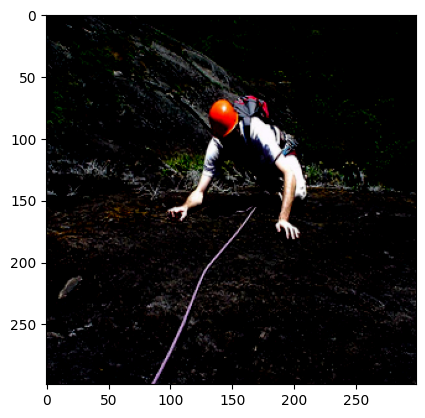

<SOS> a rock climber <UNK> . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [43]:
index = 2003
plt.imshow(train_dataset[index][0].permute(1, 2, 0))
plt.show()
result_caption_list = [train_dataset.vocab.itos[idx.item()] for idx in train_dataset[index][1]]
result_caption = " ".join(result_caption_list)
print(result_caption)

# Model Architecture

In [24]:
class EncoderCNN(nn.Module):
  def __init__(self, embed_size, train_CNN=False):
    super(EncoderCNN, self).__init__()
    self.train_CNN = train_CNN
    self.inception = models.inception_v3(weights='IMAGENET1K_V1', aux_logits = True)
    self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p = 0.5)

  def forward(self, images):
    if self.training:
        features, _ = self.inception(images)
    else:
        features = self.inception(images)

    for name, param in self.inception.named_parameters():
      if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
      else:
        param.requires_grad = self.train_CNN

    features = self.relu(features)
    features = self.dropout(features)
    return features

In [25]:
class DecoderRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
    super(DecoderRNN, self).__init__()
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
    self.linear = nn.Linear(hidden_size, vocab_size)
    self.dropout = nn.Dropout(0.5)

  def forward(self, features, captions):
    captions = self.embed(captions)
    embeddings = self.dropout(captions)
    embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
    hiddens, _ = self.lstm(embeddings)
    outputs = self.linear(hiddens)
    return outputs

In [26]:
class CNNtoRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
    super(CNNtoRNN, self).__init__()
    self.encoderCNN = EncoderCNN(embed_size)
    self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

  def forward(self, images, captions):
    features = self.encoderCNN(images)
    outputs = self.decoderRNN(features, captions)
    return outputs

  def caption_image(self, image, vocabulary, max_length=50):
    result_caption = []

    with torch.no_grad():
        x = self.encoderCNN(image).unsqueeze(0)
        states = None

        for _ in range(max_length):
            hiddens, states = self.decoderRNN.lstm(x, states)
            output = self.decoderRNN.linear(hiddens.squeeze(0))
            predicted = output.argmax(1)
            result_caption.append(predicted.item())
            x = self.decoderRNN.embed(predicted).unsqueeze(0)

            if vocabulary.itos[predicted.item()] == "<EOS>":
                print("<EOS>")
                break

    return [vocabulary.itos[idx] for idx in result_caption]

# Training

In [27]:
embed_size = 256
hidden_size = 256
vocab_size = len(train_dataset.vocab)
num_layers = 5
batch_size = 32
learning_rate = 3e-4
num_epochs = 20

In [28]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [29]:
model = CNNtoRNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size, num_layers=num_layers).to(device)

In [30]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [31]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = 0
    for images, captions in dataloader:
        
        images = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        
        outputs = model(images, captions[:, :-1])
        
        loss = criterion(outputs.reshape(-1, outputs.size(2)), captions.reshape(-1))
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    return train_loss / len(dataloader)

In [32]:
train_loss_history = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    
    train_loss_history.append(train_loss)
     
    print(f'[Epoch {epoch+1}/{num_epochs}] [Training Loss: {train_loss}]')
    
    
    # evaluating using a sample image
#     index = 2001
#     model.eval()

#     image = train_dataset[index][0].to(device)
#     result_caption_list = model.caption_image(image.unsqueeze(0), train_dataset.vocab)
#     result_caption = " ".join(result_caption_list)
#     print("Generated Caption:", result_caption) # generated caption
#     print()

#     caption_idx = train_dataset[index][1]
#     caption_list = []
#     for idx in caption_idx:
#         caption_list.append(train_dataset.vocab.itos[idx.item()])
#     caption = " ".join(caption_list)
#     print("Real Caption:", caption) # real caption
#     print()

[Epoch 1/20] [Training Loss: 1.890610863003335]
[Epoch 2/20] [Training Loss: 1.3669991492282731]
[Epoch 3/20] [Training Loss: 1.2815384777638281]
[Epoch 4/20] [Training Loss: 1.2311965997040035]
[Epoch 5/20] [Training Loss: 1.1991140556429687]
[Epoch 6/20] [Training Loss: 1.177651752879026]
[Epoch 7/20] [Training Loss: 1.1627519689529782]
[Epoch 8/20] [Training Loss: 1.149969583726212]
[Epoch 9/20] [Training Loss: 1.1401781558519295]
[Epoch 10/20] [Training Loss: 1.1313953663049479]
[Epoch 11/20] [Training Loss: 1.1242123762138276]
[Epoch 12/20] [Training Loss: 1.1178344260091366]
[Epoch 13/20] [Training Loss: 1.1120303754749976]
[Epoch 14/20] [Training Loss: 1.1070740932061267]
[Epoch 15/20] [Training Loss: 1.1020459016321205]
[Epoch 16/20] [Training Loss: 1.0980652747889281]
[Epoch 17/20] [Training Loss: 1.0933803078685354]
[Epoch 18/20] [Training Loss: 1.0896198276474542]
[Epoch 19/20] [Training Loss: 1.0863770475029475]
[Epoch 20/20] [Training Loss: 1.0829264737400612]


In [33]:
torch.save(model.state_dict(), "/kaggle/working/model1.pth")

<EOS>
Generated Caption: <SOS> <SOS> <SOS> <SOS> " a man in a man in a <UNK> a red shirt is running through the water . <EOS>

Real Caption: <SOS> a man in an orange hat starring at something . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


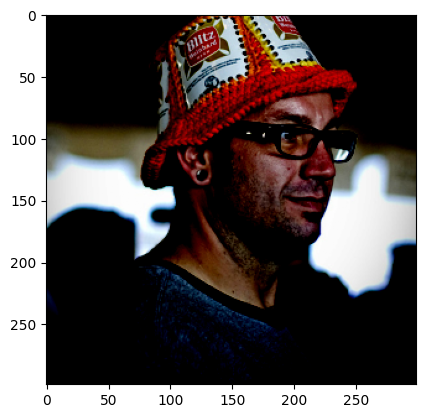

In [35]:
index = 20

model.eval()

image = train_dataset[index][0].to(device)
result_caption_list = model.caption_image(image.unsqueeze(0), train_dataset.vocab)
result_caption = " ".join(result_caption_list)
print("Generated Caption:", result_caption) # generated caption
print()

caption_idx = train_dataset[index][1]
caption_list = []
for idx in caption_idx:
    caption_list.append(train_dataset.vocab.itos[idx.item()])
caption = " ".join(caption_list)
print("Real Caption:", caption) # real caption

plt.imshow(image.cpu().numpy().transpose(1, 2, 0))
plt.show()